In [1]:
# --- 1. Setup & load ---
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = "data/housing_adequacy_dataset.csv"  # <- change if needed
AHS = 2.5  # avg household size, used for notes (Δpop/AHS ≈ needed units)

assert os.path.exists(DATA_PATH), f"Missing file: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)

# Types
df["quarter"] = pd.PeriodIndex(df["quarter"], freq="Q")
df = df.sort_values(["province","quarter"]).reset_index(drop=True)

# If HAI not present, compute it safely.
# starts_saar_q is "thousands of dwellings per quarter" (SAAR/4). Convert to dwellings:
if "hai" not in df.columns:
    starts_dwell = df["starts_saar_q"] * 1000.0
    # Avoid divide-by-zero
    denom = df["needed_units_q"].replace({0: np.nan})
    df["hai"] = starts_dwell / denom

# Convenience
df["q_dt"] = df["quarter"].dt.to_timestamp("Q")

# A clean province order (edit to taste)
PROVINCES_ORDER = ["can","nl","pe","ns","nb","qc","on","mb","sk","ab","bc"]
PROVINCE_NAMES = {
    "can": "Canada", "nl": "Newfoundland and Labrador", "pe": "Prince Edward Island",
    "ns": "Nova Scotia", "nb": "New Brunswick", "qc": "Quebec", "on": "Ontario",
    "mb": "Manitoba", "sk": "Saskatchewan", "ab": "Alberta", "bc": "British Columbia",
}

# Choose a small set for “hero” time-series slides
SELECT_PROVS = ["can","on","qc","ab","bc"]
SELECT_PROVS = [p for p in SELECT_PROVS if p in df["province"].unique()]

print("Shape:", df.shape)
df.head(3)


Shape: (1573, 10)


,quarter,province,population,starts_saar,starts_saar_q,dwelling_starts,pop_change_q,needed_units_q,hai,q_dt
0,1990Q1,ab,2520056.0,23.421667,5.855417,5855.416667,NaN,NaN,NaN,1990-03-31
1,1990Q2,ab,2532621.0,21.490333,5.372583,5372.583333,12565.0,5026.0,1.068958,1990-06-30
2,1990Q3,ab,2547788.0,13.847000,3.461750,3461.750000,15167.0,6066.8,0.570606,1990-09-30


In [2]:
# --- 2. Snapshot / coverage ---
print("Date coverage:", df["quarter"].min(), "→", df["quarter"].max())
print("\nMissing values per column:\n", df.isna().sum())

summary = (
    df.groupby("province")[["starts_saar_q","needed_units_q","hai"]]
      .agg(["count","mean","std","min","max"])
      .round(2)
)
summary


Date coverage: 1990Q1 → 2025Q3

Missing values per column:
 quarter             0
province            0
population          0
starts_saar         0
starts_saar_q       0
dwelling_starts     0
pop_change_q       11
needed_units_q     11
hai                38
q_dt                0
dtype: int64


starts_saar_q                             needed_units_q            \
                 count   mean    std    min    max          count      mean   
province                                                                      
ab                 143   7.49   2.71   2.12  16.34            142   7068.42   
bc                 143   8.31   2.66   3.12  14.15            142   6901.74   
can                143  48.68  10.57  26.42  72.67            142  39966.49   
mb                 143   1.25   0.54   0.34   2.60            142   1146.34   
nb                 143   0.86   0.33   0.31   2.20            142    372.89   
nl                 143   0.55   0.24   0.12   1.47            142    -74.27   
ns                 143   1.19   0.40   0.48   3.16            142    523.52   
on                 143  17.15   4.10   8.29  27.76            142  17093.73   
pe                 143   0.20   0.09   0.06   0.66            142    147.38   
qc                 143  10.66   3.08   4.92  21.32            142   5924.45   
sk                 143   1.01   0.55   0.21   2.80            142    719.80   

                                       hai                               
               std     min       max count  mean    std     min     max  
province                                                                 
ab         4208.89   816.0   25438.8   142  1.28   0.75    0.42    7.24  
bc         4413.32  -882.0   22959.2   142  0.55   9.86 -112.14   12.62  
can       25537.28  -492.8  167453.6   142  0.74  10.53 -123.08    6.98  
mb          974.88  -191.6    4516.8   142  1.60   1.73   -4.80   11.19  
nb          715.43  -355.6    3610.8   140  4.03  18.65  -98.97  112.64  
nl          482.59 -1316.0    1020.4   140  0.18   7.81  -43.64   42.04  
ns          945.80  -824.8    4273.2   140  1.50  14.41 -107.66   58.84  
on        11852.89 -1691.6   76590.0   142  1.91   4.73  -12.25   43.38  
pe          216.27  -142.0     975.6   123  1.21   4.64  -19.08   15.81  
qc         4409.81  -982.0   24322.0   142  3.01  19.88 -109.57  194.72  
sk         1108.02 -1405.2    4758.0   140  0.51   5.67  -52.20   23.63

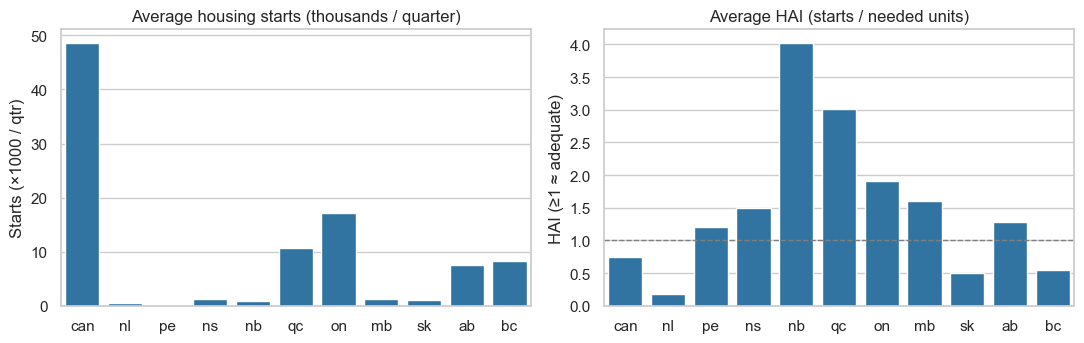

In [3]:
# --- 3. Province variation (bar charts) ---
sns.set_style("whitegrid"); sns.set_context("notebook")

order = [p for p in PROVINCES_ORDER if p in df["province"].unique()]

means = (
    df.groupby("province")[["starts_saar_q","hai"]]
      .mean()
      .reindex(order)
      .reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(11, 3.6))
sns.barplot(data=means, x="province", y="starts_saar_q", order=order, ax=axes[0])
axes[0].set_title("Average housing starts (thousands / quarter)")
axes[0].set_xlabel(""); axes[0].set_ylabel("Starts (×1000 / qtr)")

sns.barplot(data=means, x="province", y="hai", order=order, ax=axes[1])
axes[1].axhline(1, color="gray", ls="--", lw=1)
axes[1].set_title("Average HAI (starts / needed units)")
axes[1].set_xlabel(""); axes[1].set_ylabel("HAI (≥1 ≈ adequate)")

plt.tight_layout(); plt.show()


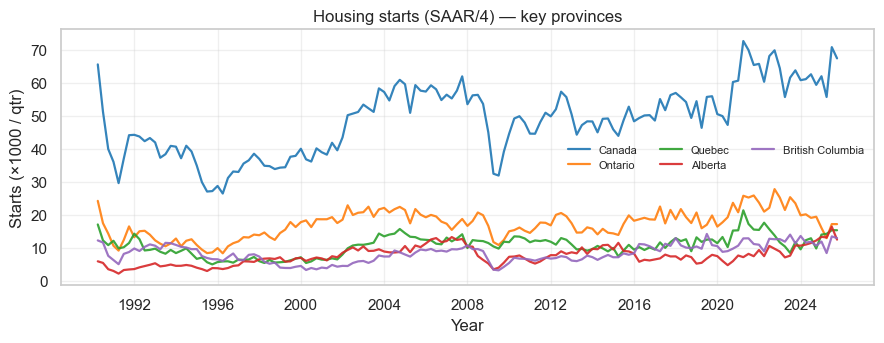

In [5]:
# --- 4. Temporal trends (overlay for key provinces) ---
plt.figure(figsize=(9, 3.6))
for p in SELECT_PROVS:
    sub = df[df["province"]==p]
    plt.plot(sub["q_dt"], sub["starts_saar_q"], label=PROVINCE_NAMES.get(p,p), lw=1.6, alpha=0.9)
plt.title("Housing starts (SAAR/4) — key provinces")
plt.xlabel("Year"); plt.ylabel("Starts (×1000 / qtr)")
plt.legend(ncol=3, fontsize=8, frameon=False)
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


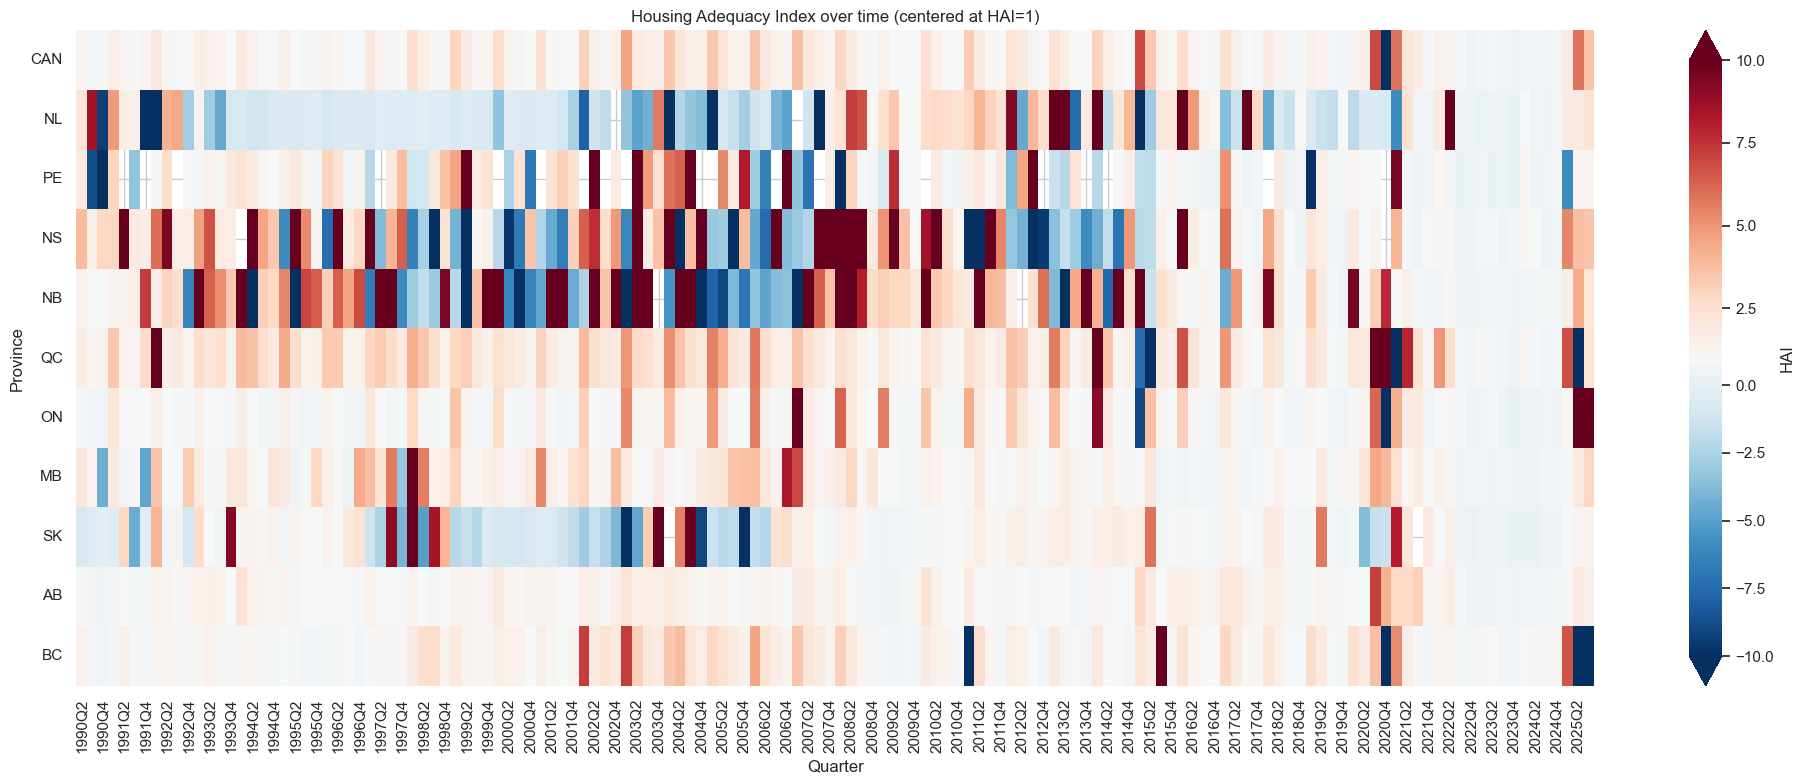

In [25]:
# --- 5. HAI heatmap (quarter × province), centered at 1 ---
pivot = df.pivot_table(values="hai", index="quarter", columns="province")
pivot = pivot[[c for c in order if c in pivot.columns]]

# Optional: clip color range
from matplotlib.colors import TwoSlopeNorm
norm = TwoSlopeNorm(vmin=-10, vcenter=1, vmax=10)

plt.figure(figsize=(20, 8))
ax = sns.heatmap(
    pivot.T,
    cmap="RdBu_r",
    norm=norm,
    cbar_kws={"label": "HAI", "extend": "both"}
)

# --- convert y-tick labels to uppercase ---
ax.set_yticklabels([label.get_text().upper() for label in ax.get_yticklabels()], rotation=0)

plt.title("Housing Adequacy Index over time (centered at HAI=1)")
plt.xlabel("Quarter"); plt.ylabel("Province")
plt.tight_layout()
plt.show()


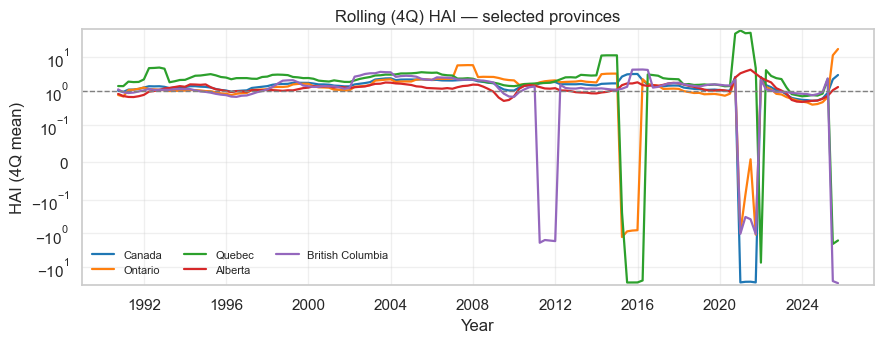

In [11]:
# --- 6. Rolling HAI (4Q mean) for selected provinces ---
plt.figure(figsize=(9, 3.6))
for p in SELECT_PROVS:
    sub = df[df["province"]==p].sort_values("quarter")
    roll = sub["hai"].rolling(4, min_periods=2).mean()
    plt.plot(sub["q_dt"], roll, label=PROVINCE_NAMES.get(p,p), lw=1.6)
plt.axhline(1, color="gray", ls="--", lw=1)
plt.title("Rolling (4Q) HAI — selected provinces")
plt.ylabel("HAI (4Q mean)"); plt.xlabel("Year")
plt.legend(ncol=3, fontsize=8, frameon=False)
plt.yscale('symlog', linthresh=0.1)
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


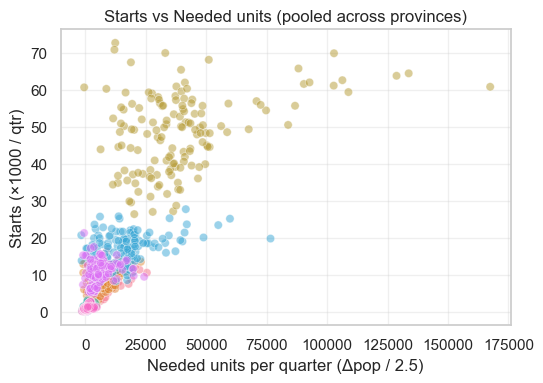

In [9]:
# --- 7. Supply vs Need (scatter) ---
plt.figure(figsize=(5.6, 4.0))
sub = df.dropna(subset=["needed_units_q","starts_saar_q"]).copy()
# Convert starts to dwellings for a more intuitive scale if you wish:
# sub["starts_dwellings"] = sub["starts_saar_q"] * 1000.0; y = "starts_dwellings"; ylab = "Starts (dwellings / qtr)"
y = "starts_saar_q"; ylab = "Starts (×1000 / qtr)"
sns.scatterplot(data=sub, x="needed_units_q", y=y, hue="province", alpha=0.5, legend=False)
plt.title("Starts vs Needed units (pooled across provinces)")
plt.xlabel("Needed units per quarter (Δpop / 2.5)"); plt.ylabel(ylab)
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


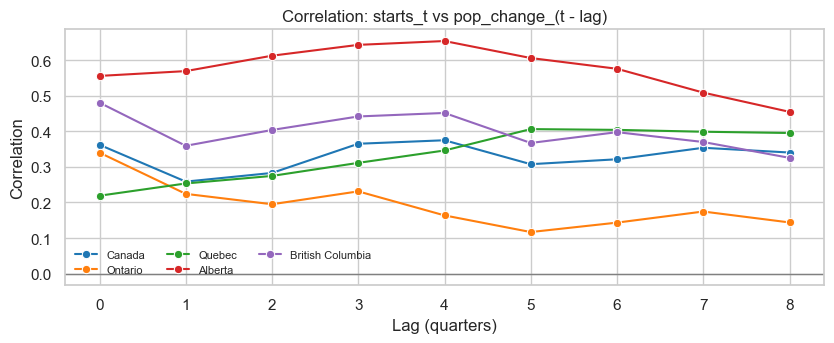

In [10]:
# --- 8. Lag correlation: starts vs lagged Δpopulation ---
def lag_corr_series(df_in, province, driver="pop_change_q", target="starts_saar_q", max_lag=8):
    sub = df_in[df_in["province"]==province].dropna(subset=[driver, target]).copy()
    sub = sub.sort_values("quarter")
    s_driver = sub[driver].reset_index(drop=True)
    s_target = sub[target].reset_index(drop=True)
    lags, cors = [], []
    for L in range(0, max_lag+1):
        c = s_target.corr(s_driver.shift(L)) if L>0 else s_target.corr(s_driver)
        lags.append(L); cors.append(c)
    return pd.DataFrame({"lag": lags, "corr": cors, "province": province})

frames = [lag_corr_series(df, p) for p in SELECT_PROVS]
lc = pd.concat(frames, axis=0, ignore_index=True)
lc["prov_name"] = lc["province"].map(PROVINCE_NAMES).fillna(lc["province"])

plt.figure(figsize=(8.5, 3.6))
sns.lineplot(data=lc, x="lag", y="corr", hue="prov_name", marker="o")
plt.axhline(0, color="gray", lw=1)
plt.title("Correlation: starts_t vs pop_change_(t - lag)")
plt.xlabel("Lag (quarters)"); plt.ylabel("Correlation")
plt.legend(ncol=3, fontsize=8, frameon=False)
plt.tight_layout(); plt.show()
